In [1]:
from typing import List, Dict

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import *
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *
from oop_functions.analytics_utils import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import itertools

from dcurves import dca, plot_graphs


In [2]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)

In [3]:

processed_data = convert_numeric_to_float16(processed_data)

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

In [4]:
cv_analytics_utils: Dict[str, CvAnalyticsUtil] = {}

In [5]:

# https://xgboost.readthedocs.io/en/latest/parameter.html
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier_entropy': RandomForestClassifier(criterion= 'entropy', n_estimators= 200), # Best one
    'RandomForestClassifier': RandomForestClassifier(criterion='entropy', n_estimators=300), # Best one
    # 'RandomForestClassifier_log_loss': RandomForestClassifier(criterion= 'log_loss', n_estimators= 300),
    # 'RandomForestClassifier_gini': RandomForestClassifier(criterion= 'gini', n_estimators= 300),
    # 'XGBClassifier_error': XGBClassifier(eval_metric= 'error', learning_rate=0.1),
    # 'XGBClassifier': XGBClassifier(eval_metric= 'logloss', learning_rate=0.1), # Best one
    # 'XGBClassifier_rmsle': XGBClassifier(objective='binary:logistic', eval_metric= 'rmsle', learning_rate=0.1),
    # 'XGBClassifier_rmse': XGBClassifier(objective='binary:logistic', eval_metric= 'rmse', learning_rate=0.1),
    # 'XGBClassifier_mae': XGBClassifier(objective='binary:logistic', eval_metric= 'mae', learning_rate=0.1),
    # 'XGBClassifier_mape': XGBClassifier(objective='binary:logistic', eval_metric= 'mape', learning_rate=0.1),
    # 'XGBClassifier_aucpr': XGBClassifier(eval_metric= 'aucpr', learning_rate=0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    # ExperimentDataHelperSingleLabelScreenedCA125First5, # 1
    # ExperimentDataHelperSingleLabelScreenedUltraFirst5, # 1
    # ExperimentDataHelperSingleLabelScreenedFirst5, # None, 1, 3, 5, 10
    # ExperimentDataHelperScreenedFirst5, # 1
    # ExperimentDataHelperSingleLabelNotScreenedColsFirst5, # None, 1
    ExperimentDataHelperScreenedColsFirst5, # 1
    # ExperimentDataHelperScreened, # 1
    # ExperimentDataHelperSingleLabelNotScreenedCols, # None, 1
    # ExperimentDataHelperAll, # None, 1
    # ExperimentDataHelperScreenedFirst5ca125AndBinary, # 1
    # ExperimentDataHelperScreenedFirst5ca125Binary, # 1
]

experiment_over_labels: Dict[str, List] = {
    ExperimentDataHelperSingleLabelScreenedCA125First5.get_name(): [1], # 1
    ExperimentDataHelperSingleLabelScreenedUltraFirst5.get_name(): [1], # 1
    ExperimentDataHelperSingleLabelScreenedFirst5.get_name(): [None, 1, 3, 5, 10], # None, 1, 3, 5, 10
    ExperimentDataHelperScreenedFirst5.get_name(): [1], # 1
    ExperimentDataHelperSingleLabelNotScreenedColsFirst5.get_name(): [None, 1], # None, 1
    ExperimentDataHelperScreenedColsFirst5.get_name(): [1], # 1
    ExperimentDataHelperScreened.get_name(): [1], # 1
    ExperimentDataHelperSingleLabelNotScreenedCols.get_name(): [None, 1], # None, 1
    ExperimentDataHelperAll.get_name(): [None, 1], # None, 1
    ExperimentDataHelperScreenedFirst5ca125AndBinary.get_name(): [1], # 1
    ExperimentDataHelperScreenedFirst5ca125Binary.get_name(): [1], # 1
}

In [6]:
num_folds=15
test_n_folds=15
train_size = 25000
# [None, 25, 35, 50, 75, 100]
top_k_features = [None]
for classifier_name, classifier in classifiers.items():
    for experiment_data_helper_class in experiment_data_helpers:
        for top_k in top_k_features:
            for year in experiment_over_labels[experiment_data_helper_class.get_name()]:
                if year:
                    label = f'cancer_in_next_{year}_years'
                else: 
                    label = 'ovar_cancer'
                filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_{label}__{num_folds}_trials'
                select_cols = None
                if top_k:
                    select_cols = feature_importance_reader(filesuffix)[:top_k]
                    filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_top_{top_k}_features_{classifier_name}_{label}__{num_folds}_trials'
                print(filesuffix)
                # print(select_cols)
                experiment_data_helper: ExperimentDataHelper = experiment_data_helper_class(processed_data, label, ['cancer_'], train_size = train_size, select_features=select_cols)
                # experiment_data_helper.set_train_size_to_max(num_folds)
                experiment_runner = ExperimentRunner(classifier, experiment_data_helper, num_folds=num_folds, test_n_folds=test_n_folds)
                cv_analytics_util = experiment_runner.run_experiment()
                cv_analytics_utils[filesuffix] = cv_analytics_util
                cv_analytics_util.store_cv_analytics_utils(filesuffix)


_for_experiment_not_screened_cols_single_label_first_5_RandomForestClassifier_ovar_cancer__15_trials
_for_experiment_not_screened_cols_single_label_first_5_RandomForestClassifier_cancer_in_next_1_years__15_trials
_for_experiment_not_screened_cols_single_label_RandomForestClassifier_ovar_cancer__15_trials
_for_experiment_not_screened_cols_single_label_RandomForestClassifier_cancer_in_next_1_years__15_trials


In [7]:
sorted_df = experiment_data_helper.source_df.sort_values(by=['plco_id'])

In [8]:
def find_different_cols(df):
    return df.columns[df.nunique() > 1]

def extract_subrecords(plco_id):
    df = sorted_df[sorted_df['plco_id'].isin([plco_id])]
    return df[find_different_cols(df)]

In [9]:
plco_ids = ['A-001979-6', 'A-002879-7']

print_df(extract_subrecords(plco_ids[0]))

+--------+-------+------------+-----------------------------+---------------------+---------+
|        |   age |   study_yr |   is_ca125_screening_record |   ovar_observe_year |   index |
|--------+-------+------------+-----------------------------+---------------------+---------|
| 307801 |    65 |         -1 |                           0 |                   8 |  307801 |
| 227729 |    60 |          5 |                           1 |                   5 |  227729 |
| 190719 |    60 |          4 |                           1 |                   4 |  190719 |
|      3 |    55 |          0 |                           1 |                   0 |       3 |
| 264704 |    60 |         -1 |                           0 |                   6 |  264704 |
| 153633 |    60 |          3 |                           1 |                   3 |  153633 |
|  78211 |    55 |          1 |                           1 |                   1 |   78211 |
| 643696 |    75 |         -1 |                           0 

In [10]:
experiment_data_helper.source_df

,ovar_cancer,ovar_behavior,ovar_histtype,plco_id,ovary_trial_flag,educat,marital,occupat,pipe,cigar,...,agelevel,ovar_cancer_years,study_yr,is_ca125_screening_record,is_ultra_screening_record,cancer_in_next_1_years,ovar_observe_year,was_screened,ph_any_not_ovar_bq,index
0,0.0,NaN,NaN,A-001799-8,1.0,5.0,1.0,1.0,0.0,0.0,...,3.0,100.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,NaN,NaN,A-001889-7,1.0,6.0,3.0,2.0,0.0,0.0,...,1.0,100.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,NaN,NaN,A-001898-8,1.0,7.0,1.0,4.0,0.0,0.0,...,0.0,100.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,NaN,NaN,A-001979-6,1.0,4.0,1.0,4.0,0.0,0.0,...,0.0,100.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3
4,0.0,NaN,NaN,A-002699-9,1.0,3.0,1.0,1.0,0.0,0.0,...,1.0,100.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658779,0.0,NaN,NaN,Z-161674-9,1.0,3.0,2.0,4.0,0.0,0.0,...,2.0,100.0,-1.0,0.0,0.0,0.0,18.0,0.0,0.0,658779
658780,0.0,NaN,NaN,Z-161683-0,0.0,7.0,1.0,1.0,0.0,0.0,...,1.0,100.0,-1.0,0.0,0.0,0.0,18.0,0.0,0.0,658780
658781,0.0,NaN,NaN,Z-161728-4,0.0,7.0,1.0,7.0,0.0,0.0,...,1.0,100.0,-1.0,0.0,0.0,0.0,18.0,0.0,0.0,658781
658782,0.0,NaN,NaN,Z-162367-9,1.0,3.0,1.0,4.0,0.0,0.0,...,1.0,100.0,-1.0,0.0,0.0,0.0,18.0,0.0,0.0,658782


In [11]:
for analytics_util in cv_analytics_util.analytics_utils: 
    print(analytics_util.get_report_generation_util().get_roc_threshold())

0.04666666666666667
0.07666666666666666
0.023333333333333334
0.03666666666666667
0.056666666666666664
0.06666666666666667
0.013333333333333334
0.043333333333333335
0.03
0.043333333333333335
0.05
0.07
0.04666666666666667
0.02666666666666667
0.023333333333333334


In [12]:
# for key, cv_analytics_util in cv_analytics_utils.items():
#     print(f"{key}: ")
#     filepath = f'./trees/decision_tree_for_{key}.png'
#     cv_analytics_util.analytics_utils[0].plot_save_tree(False, filepath)

In [13]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    cv_analytics_util.store_cv_results()

_for_experiment_not_screened_cols_single_label_first_5_RandomForestClassifier_ovar_cancer__15_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+----------+------------+
|                    |       mean |         std |      min |        max |
|--------------------+------------+-------------+----------+------------|
| precision__class_0 | 0.992817   | 0.000577811 | 0.991492 | 0.993488   |
| recall__class_0    | 0.997098   | 0.00198887  | 0.992326 | 1          |
| f1-score__class_0  | 0.994952   | 0.00102521  | 0.992724 | 0.996604   |
| precision__class_1 | 0.00143279 | 0.00398613  | 0        | 0.0140845  |
| recall__class_1    | 0.00103406 | 0.00273564  | 0        | 0.00826446 |
| f1-score__class_1  | 0.00115879 | 0.00307602  | 0        | 0.00956938 |
| accuracy           | 0.989957   | 0.00202923  | 0.985553 | 0.993231   |
| auc                | 0.552055   | 0.049049    | 0.442454 | 0.622178   |
+--------------------+------------+-------------+-----

In [14]:
# for key, cv_analytics_util in cv_analytics_utils.items():
#     print(f"{key}: ")
#     cv_analytics_util.update_thresholds(None)
#     cv_analytics_util.get_cv_report();
#     cv_analytics_util.display_graph()

In [15]:

for filesuffix, cv_analytics_util in cv_analytics_utils.items():
    label = cv_analytics_util.get_label()
    if 'single' in filesuffix:
        cv_analytics_util.merge_in_dataset(get_screened_first_5_no_process_dataset(label = label))

Added new records: 0
Added new records: 230
Added new records: 0
Added new records: 1084


In [17]:
for year in [None, 1, 3, 5, 10]:
    if year:
        label = f'cancer_in_next_{year}_years'
    else: 
        label = 'ovar_cancer'
    selected_cv_utils = {key: cv_analytics_util for key, cv_analytics_util in cv_analytics_utils.items() if cv_analytics_util.get_label() == label}
    if len(selected_cv_utils) == 0:
        continue
    intersecting_indexes = get_intersecting_indexes(selected_cv_utils)
    for filesuffix, cv_analytics_util in cv_analytics_utils.items():
        if cv_analytics_util.get_label() == label:
            cv_analytics_util.keep_indexes(intersecting_indexes)

_for_experiment_not_screened_cols_single_label_first_5_RandomForestClassifier_ovar_cancer__15_trials
Number of records: 264346
_for_experiment_not_screened_cols_single_label_RandomForestClassifier_ovar_cancer__15_trials
Number of records: 264346
Number of indersecting indexes: 264346
_for_experiment_not_screened_cols_single_label_first_5_RandomForestClassifier_cancer_in_next_1_years__15_trials
Number of records: 262934
_for_experiment_not_screened_cols_single_label_RandomForestClassifier_cancer_in_next_1_years__15_trials
Number of records: 262934
Number of indersecting indexes: 262934


_for_experiment_not_screened_cols_single_label_first_5_RandomForestClassifier_ovar_cancer__15_trials: 
[-0.0001, 0.023333333333333334, 0.03666666666666667, 0.04666666666666667, 0.06333333333333334, 1]
Threshold: 0.023333333333333334


Cross-Validation measures:
+--------------------+------------+------------+------------+-----------+
|                    |       mean |        std |        min |       max |
|--------------------+------------+------------+------------+-----------|
| precision__class_0 | 0.994529   | 0.00237323 | 0.990486   | 0.999159  |
| recall__class_0    | 0.276636   | 0.0083079  | 0.254839   | 0.287695  |
| f1-score__class_0  | 0.432799   | 0.0101618  | 0.405837   | 0.44605   |
| precision__class_1 | 0.00780379 | 0.00113593 | 0.00639104 | 0.0101777 |
| recall__class_1    | 0.787646   | 0.092217   | 0.637795   | 0.96875   |
| f1-score__class_1  | 0.0154534  | 0.00224102 | 0.0126553  | 0.0201285 |
| accuracy           | 0.2803     | 0.00813317 | 0.258859   | 0.290981  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


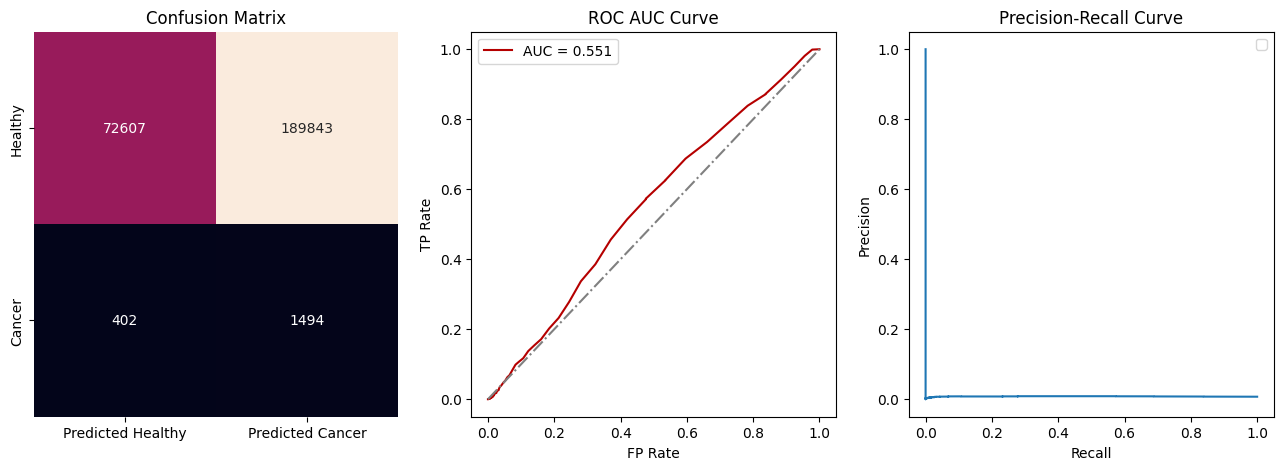

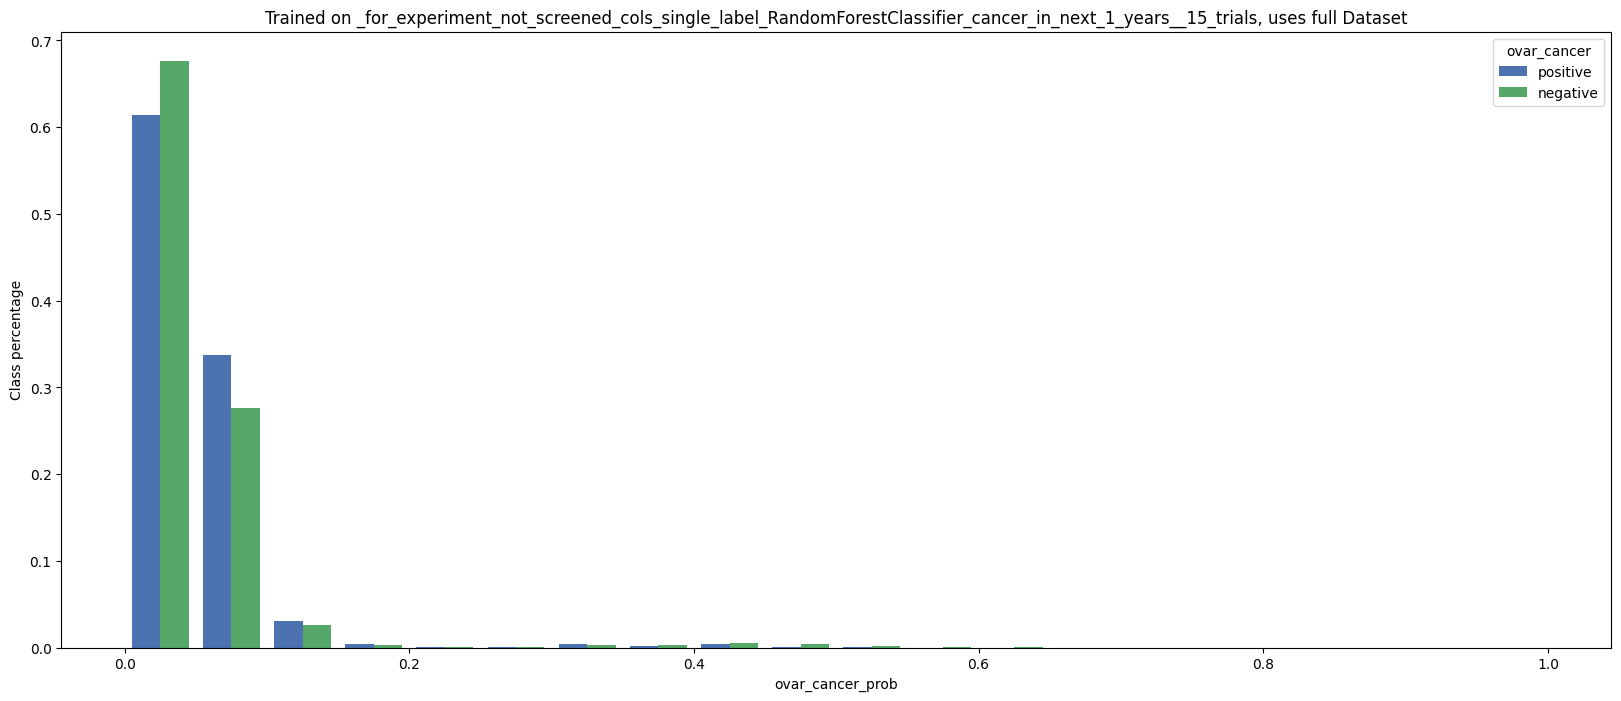

_for_experiment_not_screened_cols_single_label_first_5_RandomForestClassifier_cancer_in_next_1_years__15_trials: 
[-0.0001, 0.006666666666666667, 0.01, 0.016666666666666666, 0.03, 1]
Threshold: 0.006666666666666667


Cross-Validation measures:
+--------------------+-------------+-------------+-------------+------------+
|                    |        mean |         std |         min |        max |
|--------------------+-------------+-------------+-------------+------------|
| precision__class_0 | 0.999103    | 0.000325476 | 0.998528    | 0.999653   |
| recall__class_0    | 0.33832     | 0.010329    | 0.322714    | 0.353602   |
| f1-score__class_0  | 0.505391    | 0.0115293   | 0.487832    | 0.522351   |
| precision__class_1 | 0.000999409 | 0.000166933 | 0.000700035 | 0.00127986 |
| recall__class_1    | 0.685049    | 0.116821    | 0.470588    | 0.882353   |
| f1-score__class_1  | 0.0019959   | 0.000333387 | 0.00139799  | 0.00255602 |
| accuracy           | 0.338655    | 0.0102767   | 0.3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


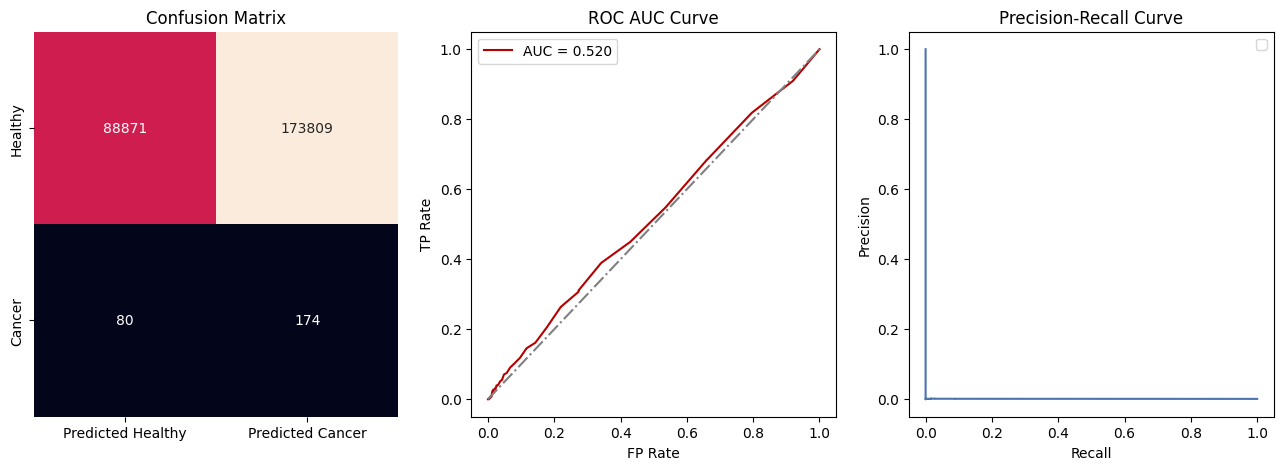

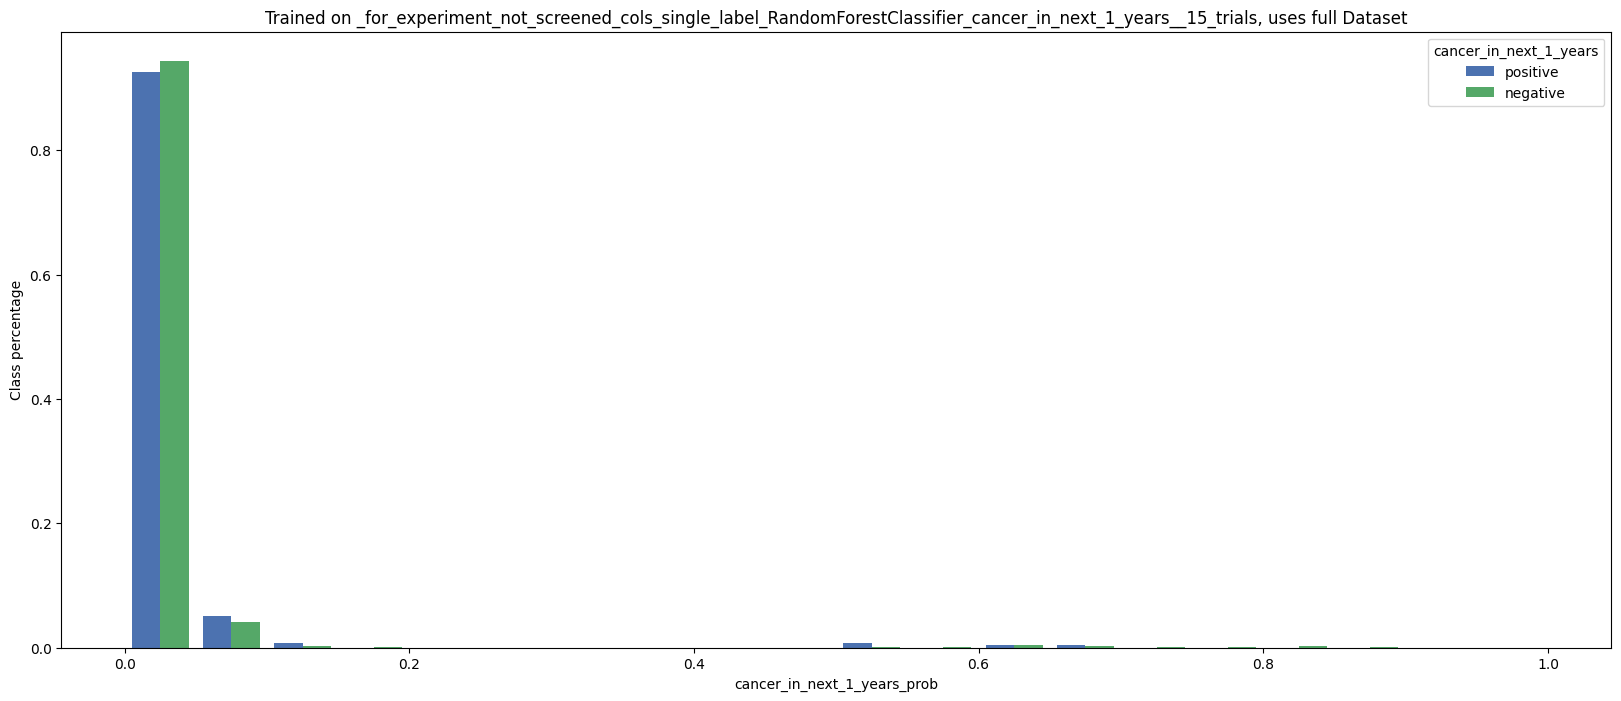

_for_experiment_not_screened_cols_single_label_RandomForestClassifier_ovar_cancer__15_trials: 
[-0.0001, 0.03, 0.04666666666666667, 0.06, 0.08, 1]
Threshold: 0.03


Cross-Validation measures:
+--------------------+-----------+------------+------------+------------+
|                    |      mean |        std |        min |        max |
|--------------------+-----------+------------+------------+------------|
| precision__class_0 | 0.994565  | 0.00217638 | 0.990694   | 0.997877   |
| recall__class_0    | 0.274632  | 0.0104206  | 0.257278   | 0.290127   |
| f1-score__class_0  | 0.430307  | 0.0126983  | 0.40891    | 0.449077   |
| precision__class_1 | 0.0077994 | 0.00095059 | 0.00627881 | 0.00947831 |
| recall__class_1    | 0.790756  | 0.0857894  | 0.622047   | 0.921875   |
| f1-score__class_1  | 0.0154455 | 0.00187583 | 0.0124321  | 0.0187519  |
| accuracy           | 0.278328  | 0.00995613 | 0.262101   | 0.293799   |
| auc                | 0.561831  | 0.0592059  | 0.451641   | 0.67542

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


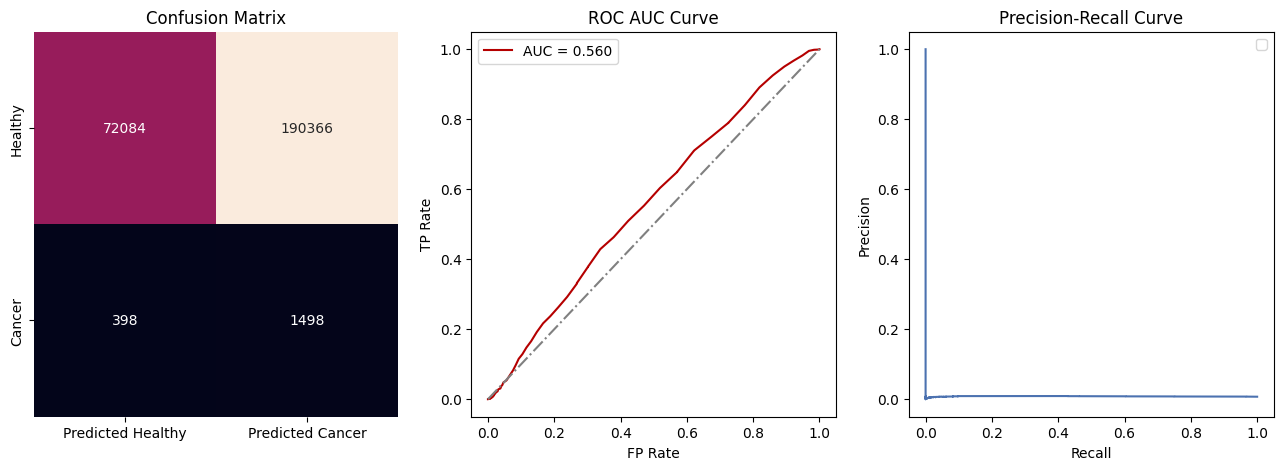

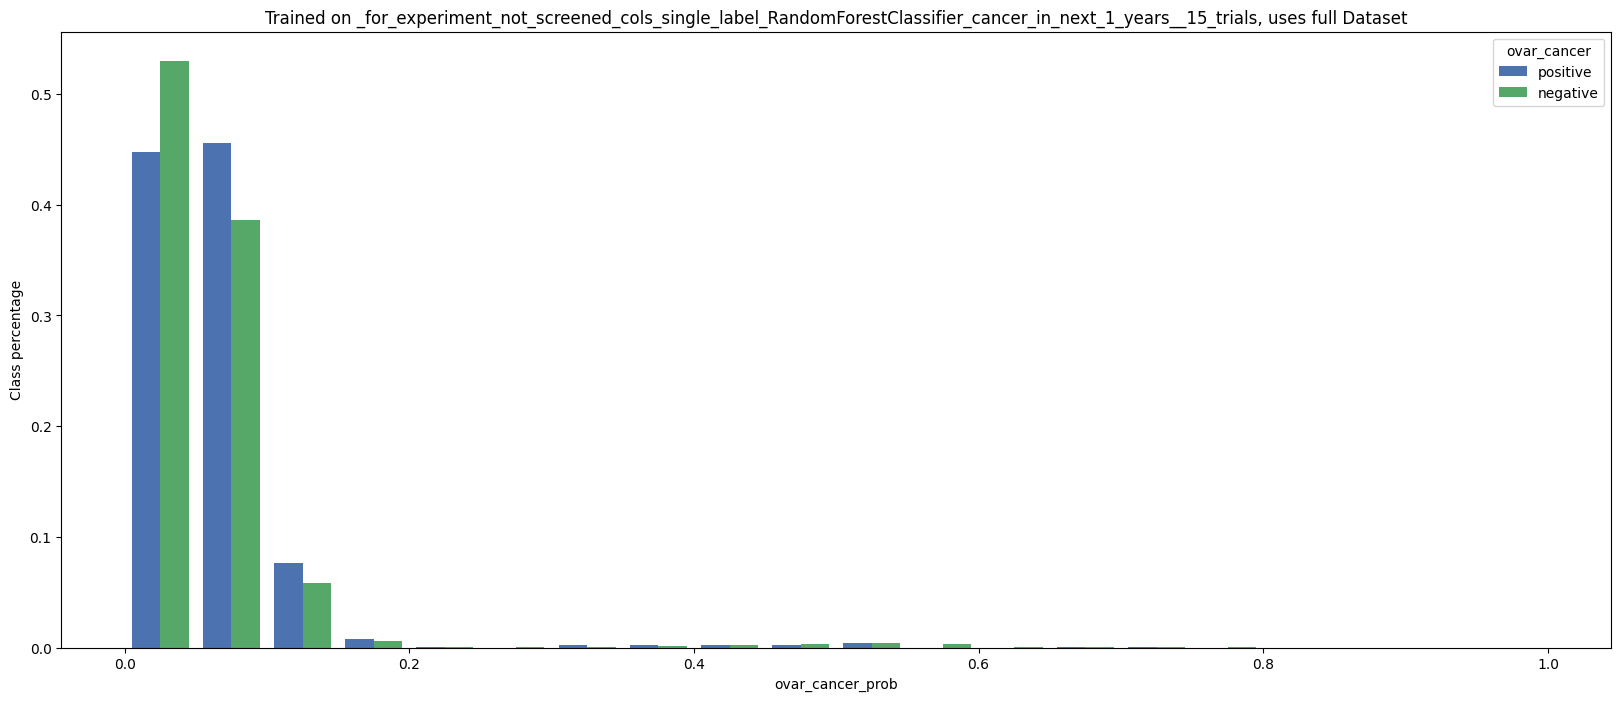

_for_experiment_not_screened_cols_single_label_RandomForestClassifier_cancer_in_next_1_years__15_trials: 
[-0.0001, 0.016666666666666666, 0.02666666666666667, 0.04, 0.06, 1]
Threshold: 0.016666666666666666


Cross-Validation measures:
+--------------------+------------+-------------+-------------+------------+
|                    |       mean |         std |         min |        max |
|--------------------+------------+-------------+-------------+------------|
| precision__class_0 | 0.998989   | 0.00124314  | 0.996491    | 1          |
| recall__class_0    | 0.210715   | 0.0184227   | 0.189465    | 0.249518   |
| f1-score__class_0  | 0.347661   | 0.0248509   | 0.318571    | 0.399201   |
| precision__class_1 | 0.00203666 | 0.000724017 | 0.000435603 | 0.00249413 |
| recall__class_1    | 0.752904   | 0.0663389   | 0.658537    | 0.829268   |
| f1-score__class_1  | 0.00406142 | 0.00144294  | 0.000870638 | 0.00497331 |
| accuracy           | 0.211232   | 0.0188692   | 0.189465    | 0.250651

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


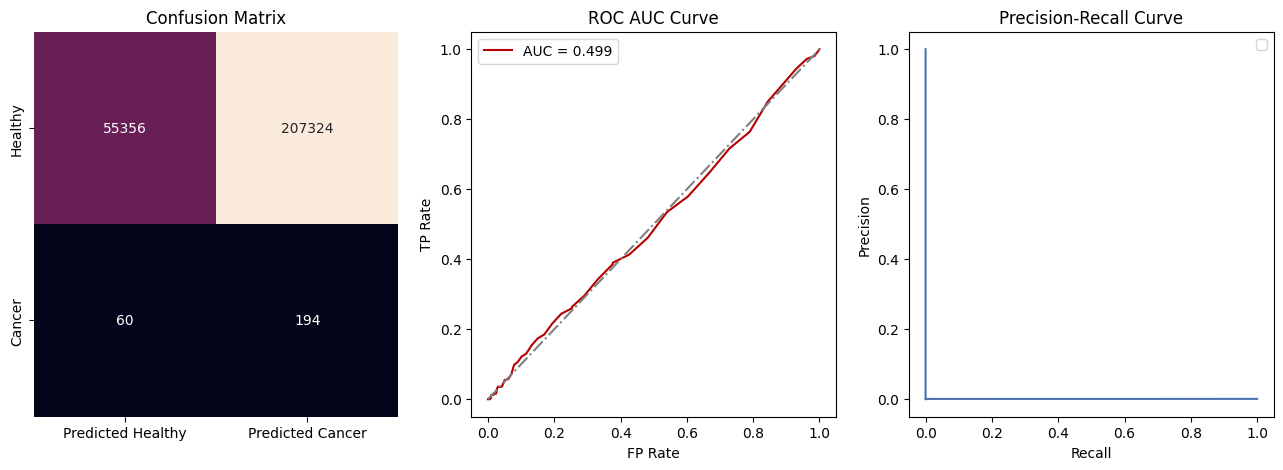

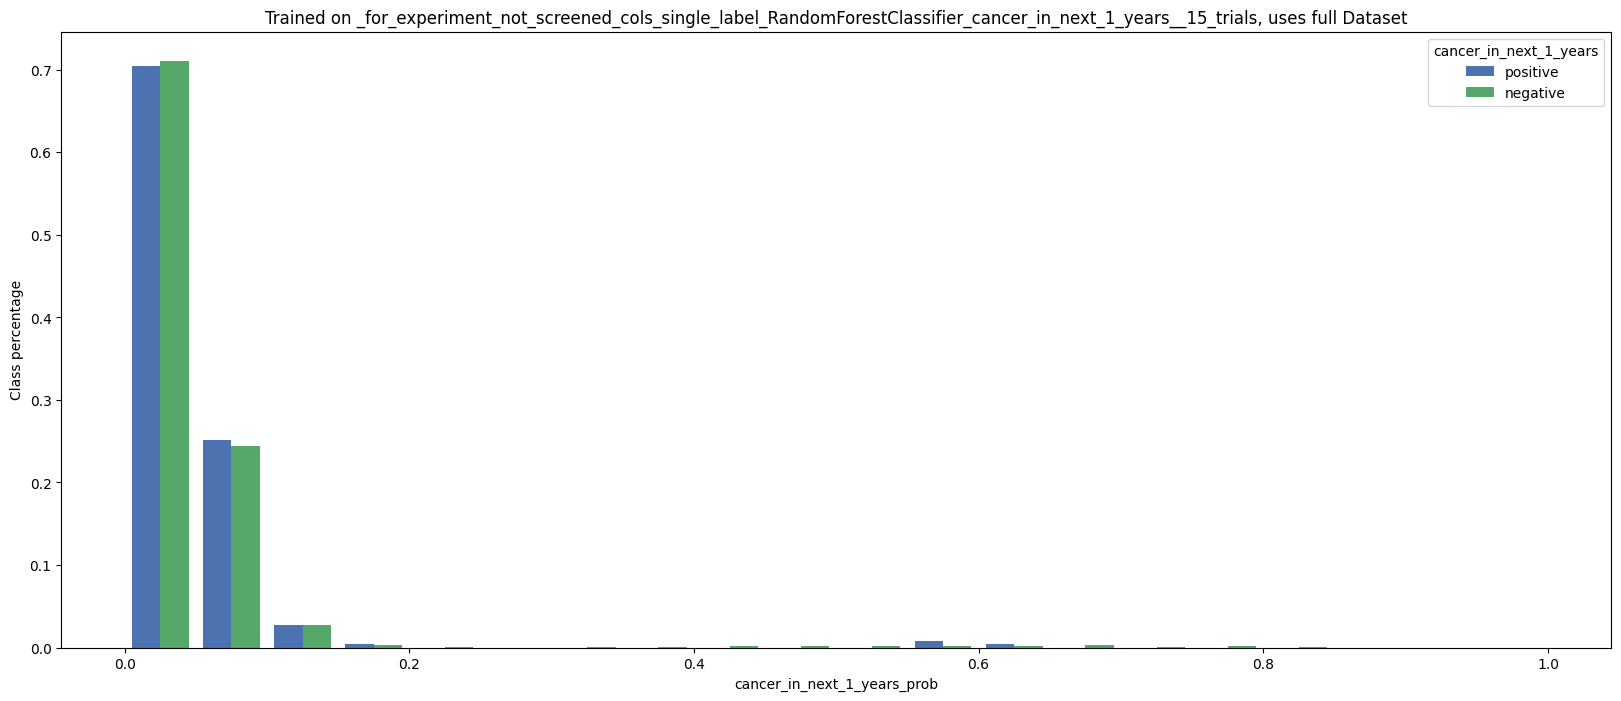

In [18]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    # Predicting actual cancer probability using bucketing
    per_thereshold_metrics = bucket_predictions_by_thresholds(cv_analytics_util)

    # General Plots
    # threshold = cv_analytics_util.get_optimal_operating_point()
    threshold = per_thereshold_metrics.loc[1, 'Threshold']
    print(f"Threshold: {threshold}")
    cv_analytics_util.update_thresholds(threshold)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    label = cv_analytics_util.get_label()
    full_dataset = cv_analytics_util.get_dataset_with_predictions()
    plot_hist_side_by_side_for_class(full_dataset, label, f'{label}_prob', normalize = True, title=f'Trained on {filesuffix}, uses full Dataset')